# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer -  prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import math 
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [4]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4719,1,38.000,26400.000,4,0
3008,0,44.000,35800.000,1,1
4277,0,25.000,37100.000,3,0
119,0,22.000,33800.000,1,0
736,0,20.000,39200.000,1,0
4578,0,19.000,40800.000,0,0
2796,1,22.000,33300.000,4,0
4002,1,20.000,48400.000,0,0
3100,0,33.000,36300.000,0,0
1894,0,36.000,28300.000,2,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:
df = df.astype({"age": int})

In [9]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


We see there are no missing values

In [1]:
# now have a look at the data's descriptive statistics. 

In [11]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000,5000.000,5000.000,5000.000,5000.000
mean,0.499,30.953,39916.360,1.194,0.148
std,0.500,8.441,9900.084,1.091,0.463
min,0.000,18.000,5300.000,0.000,0.000
25%,0.000,24.000,33300.000,0.000,0.000
50%,0.000,30.000,40200.000,1.000,0.000
75%,1.000,37.000,46600.000,2.000,0.000
max,1.000,65.000,79000.000,6.000,5.000


- The descriptive statistics look valid, ages are between 18 to 65, gender is either 0 or 1, income seems valid and so do the amount of family members.
- Regarding outliers, we might have some in our age, income and insurance_benefits, wil be handled.

In [12]:
df.duplicated().sum()

153

Since we have no unique identifier, we assume having duplicates is fine.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

We will Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

We can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use our own.

We will Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

We want to answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [15]:
#importing the kNN algorithm from scikit-learn
from sklearn.neighbors import NearestNeighbors

In [16]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])], axis=1)
    
    return df_res

Scaling the data.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1517,0.000,0.492,0.573,0.167,0
2303,0.000,0.431,0.544,0.000,0
1169,1.000,0.462,0.287,0.167,0
1654,0.000,0.677,0.486,0.167,1
1197,1.000,0.323,0.767,0.333,0


Now, let's get similar records for a given one for every combination

un-scaled euclidean distance:

In [19]:
get_knn(df[feature_names], 100, 6, 'euclidean')

,gender,age,income,family_members,distance
100,0,19,37300.000,1,0.000
1831,0,20,37300.000,2,1.414
2624,1,19,37300.000,0,1.414
4278,1,19,37300.000,2,1.414
1086,0,22,37300.000,3,3.606
1806,1,23,37300.000,0,4.243


scaled euclidean distance:

In [20]:
get_knn(df_scaled[feature_names], 100, 6, 'euclidean')

,gender,age,income,family_members,distance
100,0.000,0.292,0.472,0.167,0.000
4915,0.000,0.292,0.477,0.167,0.005
243,0.000,0.292,0.467,0.167,0.005
1323,0.000,0.292,0.457,0.167,0.015
811,0.000,0.308,0.471,0.167,0.015
4843,0.000,0.308,0.470,0.167,0.016


un-scaled manhattan distance:

In [21]:
get_knn(df[feature_names], 100, 6, 'manhattan')

,gender,age,income,family_members,distance
100,0,19,37300.000,1,0.000
1831,0,20,37300.000,2,2.000
2624,1,19,37300.000,0,2.000
4278,1,19,37300.000,2,2.000
1086,0,22,37300.000,3,5.000
1806,1,23,37300.000,0,6.000


scaled manhattan distance:

In [22]:
get_knn(df_scaled[feature_names], 100, 6, 'manhattan')

,gender,age,income,family_members,distance
100,0.000,0.292,0.472,0.167,0.000
4915,0.000,0.292,0.477,0.167,0.005
243,0.000,0.292,0.467,0.167,0.005
1323,0.000,0.292,0.457,0.167,0.015
811,0.000,0.308,0.471,0.167,0.017
4843,0.000,0.308,0.470,0.167,0.018


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

- Since kNN is a distance-based algorithm, when our data isnt scaled (larger values for features), our distances also get bigger.


- It can be noted here that the high magnitude of income affected the distance between the two points. This will impact the performance of all distance based algorithms as it will give higher weightage to variables which have higher magnitude.


- We do not want our algorithm to be affected by the magnitude of these variables. The algorithm should not be biased towards variables with higher magnitude. To overcome this problem, we can bring down all the variables to the same scale.

- We get different neighbors between scaled and not scaled data

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

when checking for 5 neighbors, The results are the same between the euclidean and manhattan distances in their mutual df (scaled or not).

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Our tasks:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

making a new column with 0 for no insurance benefits and 1 for any insurance benefit, to suit our problem, a binary classification task: Is Customer Likely to Receive Insurance Benefit


In [23]:
# calculate the target

df['insurance_benefits_received'] = np.where(df['insurance_benefits']==0 , 0, 1)
df_scaled['insurance_benefits_received'] = np.where(df_scaled['insurance_benefits']==0 , 0, 1)

In [24]:
# check for the class imbalance with value_counts()

df.insurance_benefits_received.value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

We see our classes arent balanced, with class 1 having a very small share in our target variable.
We will try adding weight to class 1 in order to balance the classes.

- upsampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.

In [25]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [26]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [27]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P=P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



We see our dummy model managed to reach F1 of 0.2 with the probabilites of 0.5 and 1.

Split the whole data in the 70:30 proportion for the training/testing parts.

In [28]:
X = df[['age', 'gender', 'income', 'family_members']]
y = df['insurance_benefits_received']

In [29]:
X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']]
y_scaled = df_scaled['insurance_benefits_received']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [31]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

creating the KNN-based classifier and measuring its quality with the F1 metric for k=1..10 for both the original data and the scaled one. 

Executing on non-scaled data:

In [33]:
f1 = []
for k in range(1,11):
    neigh = KNeighborsClassifier(n_neighbors=k,weights='distance')
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    f1.append(sklearn.metrics.f1_score(y_test, y_pred))
    eval_classifier(y_test, y_pred)
    print()

F1: 0.62
Confusion Matrix
[[0.87133333 0.02      ]
 [0.05133333 0.05733333]]

F1: 0.61
Confusion Matrix
[[0.872      0.01933333]
 [0.05266667 0.056     ]]

F1: 0.56
Confusion Matrix
[[0.876      0.01533333]
 [0.06066667 0.048     ]]

F1: 0.52
Confusion Matrix
[[0.878      0.01333333]
 [0.06533333 0.04333333]]

F1: 0.51
Confusion Matrix
[[0.882      0.00933333]
 [0.06866667 0.04      ]]

F1: 0.46
Confusion Matrix
[[0.88066667 0.01066667]
 [0.07266667 0.036     ]]

F1: 0.44
Confusion Matrix
[[0.884      0.00733333]
 [0.076      0.03266667]]

F1: 0.44
Confusion Matrix
[[0.884      0.00733333]
 [0.076      0.03266667]]

F1: 0.42
Confusion Matrix
[[0.884      0.00733333]
 [0.078      0.03066667]]

F1: 0.42
Confusion Matrix
[[0.884      0.00733333]
 [0.078      0.03066667]]



plotting the F1 score for each k value for easy understanding:

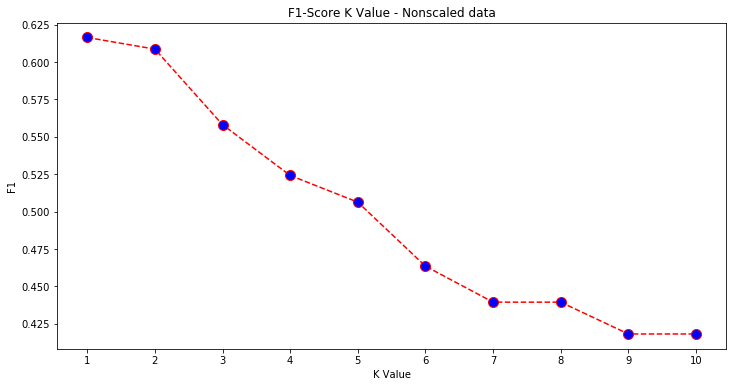

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), f1, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('F1-Score K Value - Nonscaled data')
plt.xlabel('K Value')
plt.xticks(range(1,11))
plt.ylabel('F1');

#### Description & Conclusion:

- This plot shows the quality with the F1 metric for k=1..10 for KnnClassifer.
- We see our highest F1 score was achieved when using k=1
- It seems that the more we increase K value, the worse we achieve - negative correlation.

Executing on scaled data:

In [35]:
f1_scaled = []
for k in range(1,11):
    neigh = KNeighborsClassifier(n_neighbors=k,weights='distance')
    neigh.fit(X_train_scaled, y_train_scaled)
    y_pred = neigh.predict(X_test_scaled)
    f1_scaled.append(sklearn.metrics.f1_score(y_test_scaled, y_pred))
    eval_classifier(y_test_scaled, y_pred)
    print()

F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.008      0.10066667]]

F1: 0.96
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00666667 0.102     ]]

F1: 0.95
Confusion Matrix
[[0.88866667 0.00266667]
 [0.008      0.10066667]]

F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.008      0.10066667]]

F1: 0.96
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00733333 0.10133333]]

F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00933333 0.09933333]]

F1: 0.95
Confusion Matrix
[[0.89       0.00133333]
 [0.00933333 0.09933333]]

F1: 0.94
Confusion Matrix
[[0.88933333 0.002     ]
 [0.01       0.09866667]]



plotting the F1 score for each k value for easy understanding:

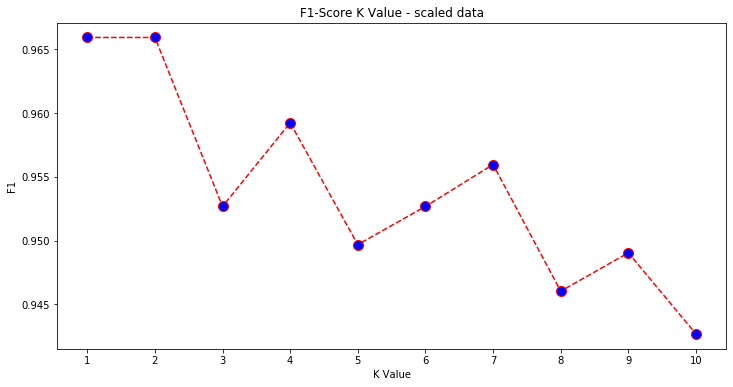

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), f1_scaled, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('F1-Score K Value - scaled data')
plt.xlabel('K Value')
plt.xticks(range(1,11))
plt.ylabel('F1');

#### Description & Conclusion:

- This plot shows the F1 score for each k value.
- We see our scores are very close to the perfect 1 score, with k value 1 and 2 reaching almost 0.97 F1 score.
- We conclude that as suspected, scaling has a massive impact on the effectiveness of distance-based algorithms such as KNN.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, we will evaluate what RMSE would be for a Linear Regression model.

we will Build your own implementation of LR and Check RMSE for both the original data and the scaled one. Can we see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [37]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.w = None
    
    def fit(self, train_features, train_target):
        
        # adding the unities
        #X = np.append(np.ones([len(X), 1]), X, axis=1)
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T@X)@X.T@y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
                
        return test_features.dot(self.w) + self.w0

In [38]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

Running on non-scaled data:

In [39]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.w)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 3.57495491e-02  1.64272726e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


Running on scaled data:

In [40]:
X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train_scaled)
print(lr.w)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_pred)

[ 2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


#### Conclusion:
- The scaling didnt affect our RMSE or R2, as scaling does not affect our statistical inference in regression models — the estimates are adjusted appropriately and the p-values will be the same. 
  The exception, is when you apply regularization. Then linear scaling can change the results dramatically. 

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

We will try to do that and check how the features' values will look like after the transformation. The intertible property is important here so make sure that $P$ is indeed invertible.


In [41]:
# np.set_printoptions(suppress=False,
#    formatter={'float_kind':'{:0.5f}'.format})

In [42]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [43]:
X = df_pn.to_numpy()

In [44]:
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generating a random matrix $P$.

In [45]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [46]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Obfuscating by multiplying the numerical features ( matrix 𝑋 ) by invertible matrix 𝑃

In [47]:
X = X @ P

Can we guess the customers' ages or income after the transformation?

In [48]:
X

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

We can't guess the customers' ages or income after the transformation.

Can we recover the original data from $X'$ if you know $P$?

Recovering the data by multiplying with  the inverse of P

In [49]:
X = X @ np.linalg.inv(P)
X

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

We will print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

Original data for first 5 customers:

In [50]:
X = df_pn.to_numpy()
X[:5,:]

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       [0.00e+00, 2.10e+01, 4.17e+04, 2.00e+00],
       [1.00e+00, 2.80e+01, 2.61e+04, 0.00e+00]])

Transformed data for first 5 customers:

In [51]:
X = X @ P
X[:5,:]

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       [ 5345.60393712, 18803.22720286, 15479.14837264, 38663.06186284],
       [ 3347.17673462, 11782.82928336,  9699.99894205, 24211.27337753]])

Reversed (recovered) data for first 5 customers:

In [52]:
X = X @ np.linalg.inv(P)
X[:5,:]

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       [-1.08907770e-12,  2.10000000e+01,  4.17000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  2.61000000e+04,
        -1.52424205e-12]])

We can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

- The reason is, because float values are never the exact values, they always have some error in them.
The numbers are very close to the values.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.


We will Build a procedure or a class that runs Linear Regression optionally with the obfuscation. 

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Do we see any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Obfuscate by multiplying the numerical features ( matrix 𝑋 ) by invertible matrix 𝑃
- Use $XP$ as the new feature matrix

Running on original data:

In [53]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


Running on obfuscated data:

In [54]:
#creating square matrix P of random numbers:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [55]:
#making sure that its invertible
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [56]:
# Obfuscate by multiplying the numerical features ( matrix 𝑋 ) by invertible matrix 𝑃
X = X @ P

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


# Conclusions

- Obfuscation doesnt affect the RMSE and R2 metrics, or the linear regression quality.

- Scaling is very important in distance based algorithms such as KNN.

- Scaling does not affect our statistical inference in simple linear regression — the estimates are adjusted appropriately and the p-values will be the same. 